In [38]:
import numpy as np 
from scipy.integrate import quad 
import os
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from pathos.multiprocessing import ProcessingPool
from functools import partial
from matplotlib.colors import LogNorm
import pandas as pd
import datetime
plt.rcParams['figure.figsize'] = (10, 8) 

In [58]:
def phi_0(k_length) -> float:
    solution = 2 ** (3/2) / np.pi / (1 + k_length**2)**2
    return solution


def A_x(t, T, w, phase, eplison, A_0) -> float:
    val = A_0 / np.sqrt(1 + eplison**2) * np.sin(np.pi * t / T)**2 * np.cos(w * t + phase)
    return val


def A_y(t, T, w, phase, eplison, A_0) -> float:
    val = A_0 / np.sqrt(1 + eplison**2) * np.sin(np.pi * t / T)**2 * eplison * np.sin(w * t + phase)
    return val


def cos_integral(t, T, omega, phi):
    return 1/64*(-(4*T*np.sin(2*((np.pi*t)/T + t*omega + phi)))/(T*omega + np.pi) 
                 + (T*np.sin(2*((2*np.pi*t)/T + t*omega + phi)))/(T*omega + 2*np.pi)
                 - (4*T*np.sin((2*np.pi*t)/T - 2*(t*omega + phi)))/(np.pi - T*omega) 
                 + (T*np.sin((4*np.pi*t)/T - 2*(t*omega + phi)))/(2*np.pi - T*omega) 
                 - (8*T*np.sin((2*np.pi*t)/T))/np.pi + (T*np.sin((4*np.pi*t)/T))/np.pi 
                 + (6*np.sin(2*phi)*np.cos(2*t*omega))/omega + (6*np.cos(2*phi)*np.sin(2*t*omega))/omega 
                 + 12*t)


def sin_integral(t, T, omega, phi):
    return 1/64*((4*T*np.sin(2*((np.pi*t)/T + t*omega + phi)))/(T*omega + np.pi) 
                 - (T*np.sin(2*((2*np.pi* t)/T + t*omega + phi)))/(T*omega + 2*np.pi)
                 + (4*T*np.sin((2*np.pi*t)/T - 2*(t*omega + phi)))/(np.pi - T*omega) 
                 + (T*np.sin((4*np.pi*t)/T - 2*(t*omega + phi)))/(T*omega - 2*np.pi)
                 - (8* T *np.sin((2*np.pi* t)/T))/np.pi + (T* np.sin((4*np.pi* t)/T))/np.pi
                 - (6* np.sin(2* phi) *np.cos(2* t* omega))/omega 
                 - (6*np.cos(2*phi)*np.sin(2*t*omega))/omega + 12*t)


def sin2sin(t, omega, phase, T):
    plus_pi = omega + np.pi * 2 / T
    minus_pi = omega - np.pi * 2 / T
    cos_terms = (-1 / plus_pi * np.cos(plus_pi * t + phase) -
                           1 / minus_pi * np.cos(minus_pi * t + phase) +
                           2 / omega * np.cos(omega * t + phase))
    return cos_terms

def sin2cos(t, omega, phase, T):
    plus_pi = omega + np.pi * 2 / T
    minus_pi = omega - np.pi * 2 / T
    sin_terms = (1 / plus_pi * np.sin(plus_pi * t + phase) + 1 / minus_pi * np.sin(minus_pi * t + phase) -
                 2 / omega * np.sin(omega * t + phase))
    return sin_terms

i = complex(0, 1)

def M_SFA_VG(t_f: float, t_0: float, k: np.array, w_sim: float,
             A_0: float, E_0: float, phase: float, epsilon: float, T_f: float, 
             cos2_zero, sin2_zero, cos_zero, sin_zero
            ) -> float:
    
    k_squared = k[0]**2 + k[1]**2 + k[2]**2
    
    # I need to make for kx and ky
    
    # kx here first k[0]
    if k[0] != 0:
        i_x = lambda ts: k[0] * np.sin(np.pi * ts / T_f)**2 * np.cos(w_sim * ts + phase) * np.exp(
            (-1) * i * E_0 * ts +
                 # k^2
            i * 1 / 2 * (k_squared * ts + 
                 # k*A
                 2 * A_0 / np.sqrt(1 + epsilon**2) * (
                     k[0] * (sin2cos(t=ts, omega=w_s, phase=phase_s, T=T_s) - cos_zero) +
                     k[1] * epsilon * (sin2sin(t=ts, omega=w_s, phase=phase_s, T=T_s) - sin_zero)
                                                 ) 
                 # A_0**2
                  + A_0**2 / (1 + epsilon**2) * (cos_integral(t=ts, T=T_s, omega=w_s, phi=phase_s) -
                                                 cos2_zero +
                                              epsilon**2 * (sin_integral(t=ts, T=T_s, omega=w_s, phi=phase_s) -
                                                 sin_zero)
                                             )
                )
        )
        sol_large_x = quad(i_x, t_0, t_f, complex_func=True, limit=15)
    else:
        sol_large_x = [0, 0]
    
    # ky here first k[1]
    if k[1] != 0:
        i_y = lambda ts: k[1] * np.sin(np.pi * ts / T_f)**2 * epsilon * np.sin(w_sim * ts + phase) * np.exp(
            (-1) * i * E_0 * ts +
                 # k^2
            i * 1 / 2 * (k_squared * ts + 
                 # k*A
                 2 * A_0 / np.sqrt(1 + epsilon**2) * (
                     k[0] * (sin2cos(t=ts, omega=w_s, phase=phase_s, T=T_s) - cos_zero) +
                     k[1] * epsilon * (sin2sin(t=ts, omega=w_s, phase=phase_s, T=T_s) - sin_zero)
                                                 ) 
                 # A_0**2
                  + A_0**2 / (1 + epsilon**2) * (cos_integral(t=ts, T=T_s, omega=w_s, phi=phase_s) -
                                                 cos2_zero +
                                              epsilon**2 * (sin_integral(t=ts, T=T_s, omega=w_s, phi=phase_s) -
                                                 sin_zero)
                                             )
                )
        )
        sol_large_y = quad(i_y, t_0, t_f, complex_func=True, limit=10)
    else:
        sol_large_y = [0, 0]
    
    
    full_integral =  A_0 / np.sqrt(1 + epsilon**2) * (sol_large_y[0] + sol_large_x[0])
    
    M = (-1) * i * phi_0(k_squared) * full_integral
    
    return M
    
    
def dp_dk(M: complex) -> float:
    return M.real**2 + M.imag**2
    
    
def plot_log(xs, ys, vals) -> None:
    fig, ax = plt.subplots()
    im = ax.scatter(xs, ys, c=vals, norm=LogNorm())

    ax.invert_yaxis()

    ax.set(xlabel=r"$k_x$", ylabel=r"$k_y$")
    ax.tick_params(direction="inout", right=True, top=True)

    cbar = fig.colorbar(im, ax=ax, label=r'$|M^{SFA, VG}_{k, 0}|^2$')
    plt.show()
    
    return


def plt_pkl(file: str, log: bool = True):
    
    df = pd.read_pickle(file)
    pivot_table = df.pivot(index='ky', columns='kx', values='dpdk')
    # Plot using imshow
    if log:
        plt.imshow(pivot_table, cmap='viridis', origin='lower', aspect='auto', norm=LogNorm())
    else:
        plt.imshow(pivot_table, cmap='viridis', origin='lower', aspect='auto')
        
    plt.colorbar(label='dpdk')

    # Set titles and labels
    plt.title("Heatmap of dpdk values")
    plt.xlabel("kx")
    plt.ylabel("ky")

    # Set x and y ticks at regular intervals
    num_ticks = 10  # Set the number of ticks you want
    kx_ticks = np.linspace(0, len(pivot_table.columns) - 1, num_ticks, dtype=int)
    ky_ticks = np.linspace(0, len(pivot_table.index) - 1, num_ticks, dtype=int)

    plt.xticks(kx_ticks, labels=[f"{pivot_table.columns[i]:.1f}" for i in kx_ticks])
    plt.yticks(ky_ticks, labels=[f"{pivot_table.index[i]:.1f}" for i in ky_ticks])

    # Display the plot
    plt.show()

def plt_pkl_diff(file2: str, file1: str, log: bool = True):
    df1 = pd.read_pickle(file2)
    df2 = pd.read_pickle(file1)
    df = df1.copy()
    df["dpdk1"] = df1["dpdk"] - df2["dpdk"]
    if log:
        return plot_log(df["kx"], 
                        df["ky"], 
                        df["dpdk1"])
    else:
        return plot(df["kx"], 
                df["ky"], 
                df["dpdk1"])
    

def plot(xs, ys, vals) -> None:
    fig, ax = plt.subplots()
    im = ax.scatter(xs, ys, c=vals)

    ax.tick_params(direction="inout", right=True, top=True)
    ax.set(xlabel=r"$k_x$", ylabel=r"$k_y$")

    fig.colorbar(im, ax=ax, label=r'$|M^{SFA, VG}_{k, 0}|^2$')
    return

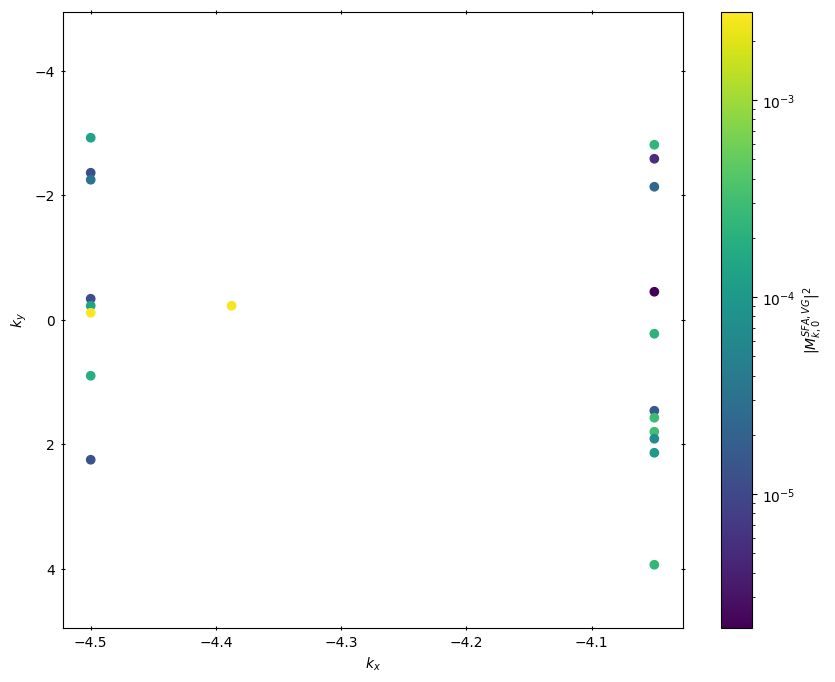

In [40]:
plt_pkl_diff("A2_is_0_15_windows.pkl", "Standard.pkl", log=True)

### Standard values

In [45]:
I = 5e13
convertion_I_au = 3.51e16
I_au = I / convertion_I_au
F_0 = np.sqrt(I_au)

conversion_ev_au = 27.21
w_800 = 1.56 / conversion_ev_au
w_s = w_800 * 800 / 400 # 300 nm

A_0_s = F_0 / w_s

E_0_s = -13.6 / conversion_ev_au

N_s = 10
T_C_s = 2 * np.pi / w_s
T_s = N_s * T_C_s

phase_s = 0.5
epsilon_s = 1
A_0_s, A_0_s**2

(0.32915874037472703, 0.10834547636507695)

In [46]:
k_test = np.array([1, 1, 0])

cos2_zero = cos_integral(t=0, T=T_s, omega=w_s, phi=phase_s)
sin2_zero = sin_integral(t=0, T=T_s, omega=w_s, phi=phase_s)
sin_zero = sin2sin(t=0, T=T_s, omega=w_s, phase=phase_s)
cos_zero = sin2cos(t=0, T=T_s, omega=w_s, phase=phase_s)

val = M_SFA_VG(t_f=T_s, t_0=0, k=k_test, w_sim=w_s, A_0=A_0_s, E_0=E_0_s, phase=phase_s,
         epsilon=epsilon_s, T_f=T_s, cos2_zero=cos2_zero, sin2_zero=sin2_zero, cos_zero=cos_zero, 
               sin_zero=sin_zero)

In [47]:
dp_dk(val)

0.0077349565575252225

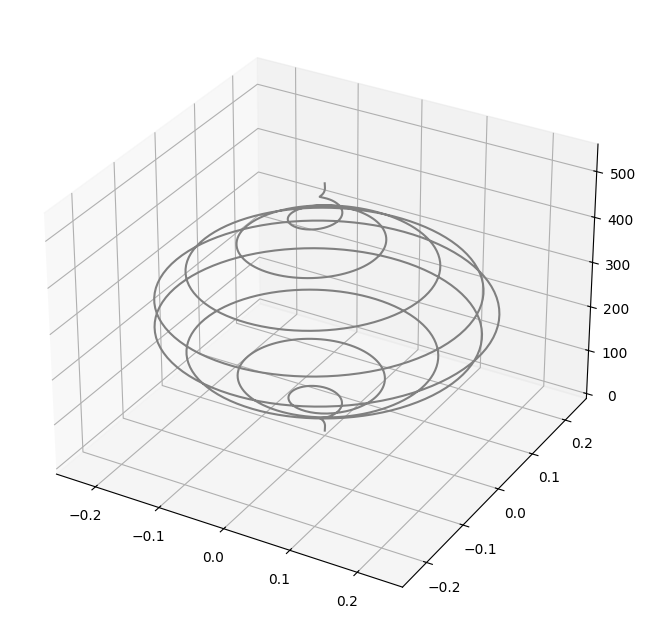

In [59]:
ts = np.linspace(0, T_s, 1000)
Ax_vals = [A_x(t, T_s, w_s, phase_s, epsilon_s, A_0_s) for t in ts]
Ay_vals = [A_y(t, T_s, w_s, phase_s, epsilon_s, A_0_s) for t in ts]

all_vals = [[A_x(t, T_s, w_s, phase_s, epsilon_s, A_0_s), 
             A_y(t, T_s, w_s, phase_s, epsilon_s, A_0_s)] for t in ts]
ax = plt.axes(projection='3d')
# ax.scatter3D(Ax_vals, Ay_vals, ts, c=ts, cmap='Greens')
ax.plot3D(Ax_vals, Ay_vals, ts, 'grey')
plt.show()

In [49]:
tic = datetime.datetime.now()
def compute_values(kx, kys, T_s, w_s, A_0_s, E_0_s, phase_s):
    return [dp_dk(M_SFA_VG(t_f=T_s, t_0=0, k=np.array([kx, ky, 0]), w_sim=w_s, A_0=A_0_s, E_0=E_0_s, 
                       phase=phase_s, cos2_zero=cos2_zero, sin2_zero=sin2_zero, cos_zero=cos_zero,
                           sin_zero=sin_zero, epsilon=1, T_f=T_s)) for ky in kys]

length = 233

start_val_x = -0.5
end_val_x = 0.5

start_val_y = -0.5
end_val_y = 0.5

kxs = np.linspace(start_val_x, end_val_x, length)
kys = np.linspace(start_val_y, end_val_y, length)

cos2_zero = cos_integral(t=0, T=T_s, omega=w_s, phi=phase_s)
sin2_zero = sin_integral(t=0, T=T_s, omega=w_s, phi=phase_s)
sin_zero = sin2sin(t=0, T=T_s, omega=w_s, phase=phase_s)
cos_zero = sin2cos(t=0, T=T_s, omega=w_s, phase=phase_s)

# Create a pool of worker processes using pathos
pool = ProcessingPool()  

# Create a partial function with fixed arguments except for kx
partial_compute_values = partial(
    compute_values, kys=kys, T_s=T_s, w_s=w_s, A_0_s=A_0_s, E_0_s=E_0_s, phase_s=phase_s)

# Map the partial function to kxs
results = pool.map(partial_compute_values, kxs)

kx_plot = np.repeat(kxs, length)
ky_plot = np.tile(kys, length)
values_plot = np.concatenate(results)

toc = datetime.datetime.now()
print(f"Finished, length: {length}, time: {toc - tic}")


Finished, length: 233, time: 0:05:33.812147


Functions, time: 25.381660 length: 10 

Functions, time: 0:47:09.744985 length: 701

Quads, time: 1:27.857284 length: 10 3.6 forbedring 

In [19]:
values_plot

array([0.00353856, 0.00737599, 0.01002385, ..., 0.00129591, 0.00066918,
       0.00609144])

In [50]:
df = pd.DataFrame()
df["kx"] = kx_plot
df["ky"] = ky_plot
df["dpdk"] = values_plot
pivot_table = df.pivot(index='ky', columns='kx', values='dpdk')
df.to_pickle("New_Standard_N_10_w_400_limit_15.pkl")

In [60]:
df = pd.read_pickle("New_Standard_N_10.pkl")
pivot_table = df.pivot(index='ky', columns='kx', values='dpdk')

9
10
11
12
13
14
15
16
17
18
19


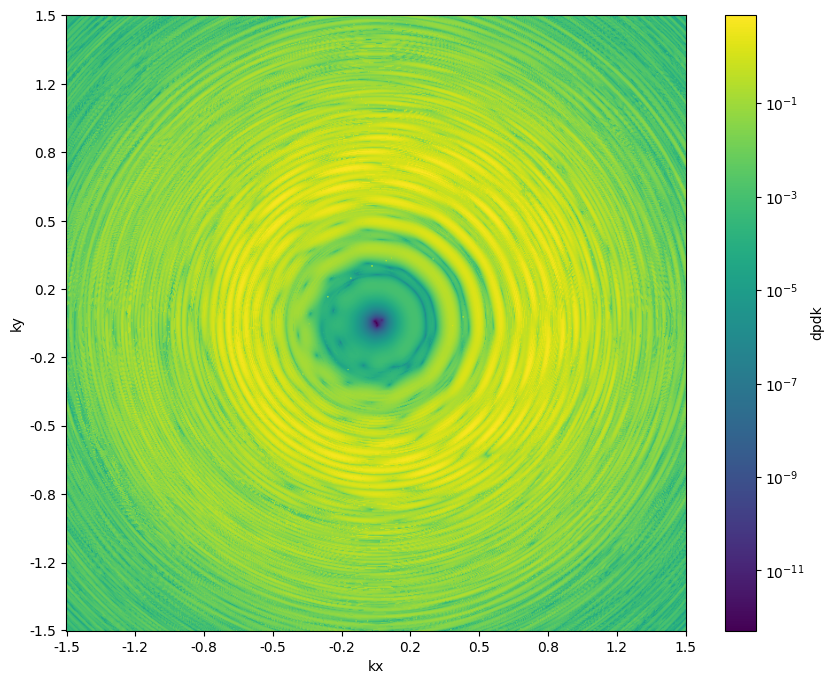

In [79]:
# Plot using imshow
w_s = w_800 * 800 / 810 # 300 nm
log = True
if log:
    plt.imshow(pivot_table, cmap='viridis', origin='lower', aspect='auto', norm=LogNorm())
else:
    plt.imshow(pivot_table, cmap='viridis', origin='lower', aspect='auto')

plt.colorbar(label='dpdk')

offset = len(pivot_table.columns) / 2 
for i in range(5,20):
    inside_r = i * w_s + E_0_s
    if inside_r > 0:
        print(i)
       # print(inside_r)
        r = np.sqrt(2 * (inside_r))
        theta = np.linspace(0, 2 * np.pi, 100)
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        #plt.plot(x*offset/1.5 + offset, y*offset/1.5 + offset, c="black", ls="--", alpha=0.5)
    
# Set titles and labels
plt.xlabel("kx")
plt.ylabel("ky")

# Set x and y ticks at regular intervals
num_ticks = 10  # Set the number of ticks you want
kx_ticks = np.linspace(0, len(pivot_table.columns) - 1, num_ticks, dtype=int)
ky_ticks = np.linspace(0, len(pivot_table.index) - 1, num_ticks, dtype=int)

#plt.plot(np.array(Ax_vals)*offset/1.5 + offset, np.array(Ay_vals)*offset/1.5 + offset, color="white", alpha=0.5)

plt.xticks(kx_ticks, labels=[f"{pivot_table.columns[i]:.1f}" for i in kx_ticks])
plt.yticks(ky_ticks, labels=[f"{pivot_table.index[i]:.1f}" for i in ky_ticks])

# Display the plot
plt.show()

### Old method

In [38]:
from scipy.stats import gaussian_kde

In [40]:
data = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 3]], 200)
x, y = data.T
nbins = 20
k = gaussian_kde(data.T)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

In [43]:
kx_plot

array([-2., -2., -2., ...,  2.,  2.,  2.])

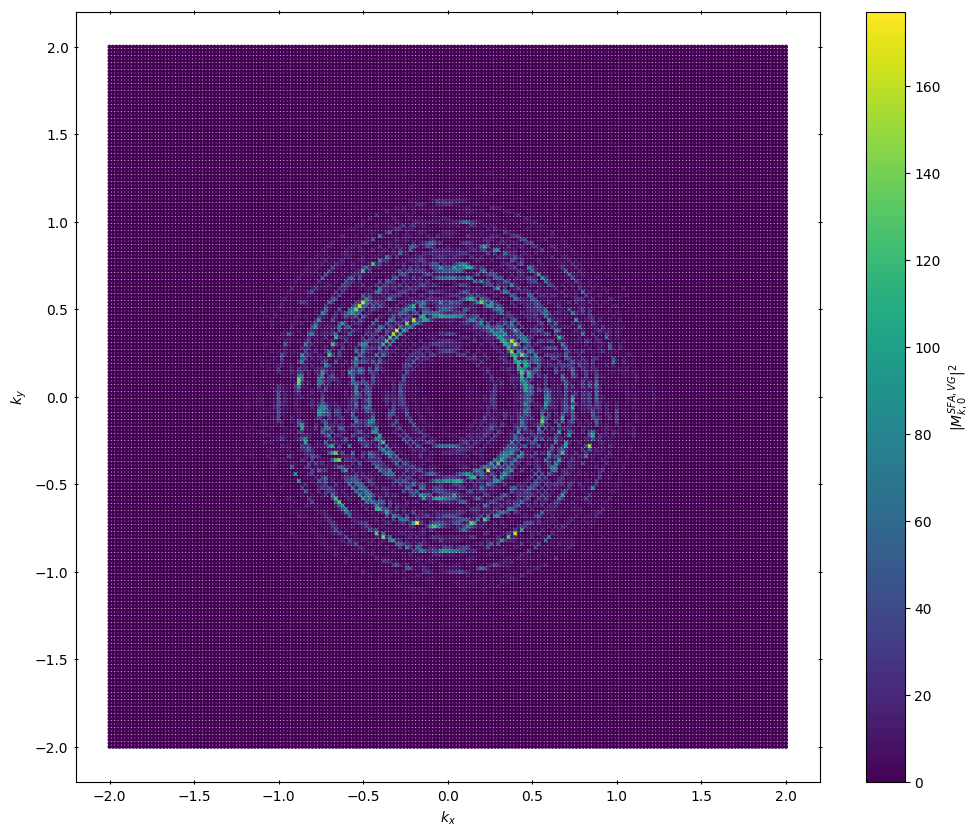

In [35]:
fig, ax = plt.subplots()
im = ax.scatter(kx_plot, ky_plot, c=values_plot, s=4)

ax.tick_params(direction="inout", right=True, top=True)
ax.set(xlabel=r"$k_x$", ylabel=r"$k_y$")

fig.colorbar(im, ax=ax, label=r'$|M^{SFA, VG}_{k, 0}|^2$')

In [30]:
df = pd.DataFrame()
df["kx"] = kx_plot
df["ky"] = ky_plot
df["dpdk"] = values_plot
df.to_pickle("New_Standard_N_.pkl")

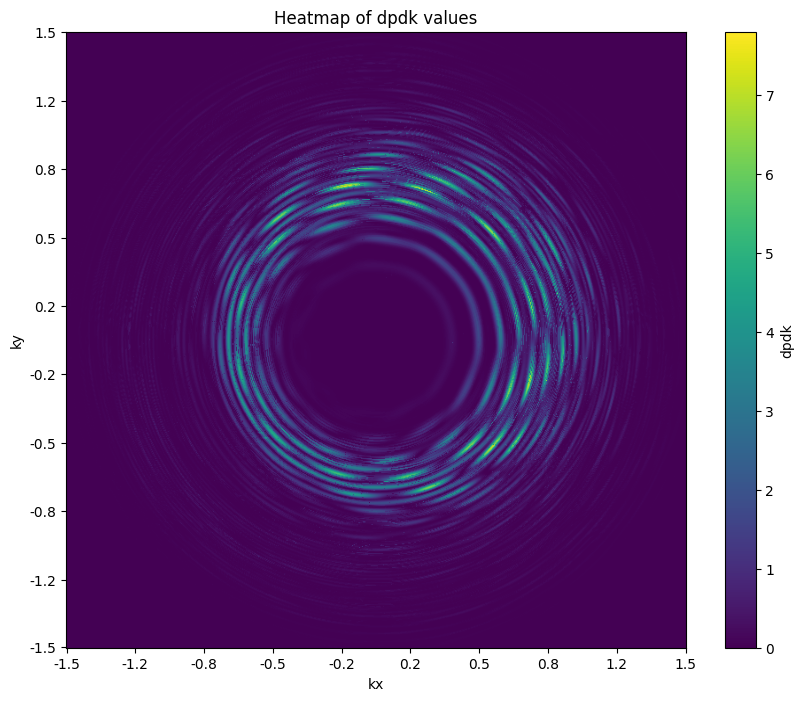

In [57]:
plt_pkl("New_Standard_N_10.pkl", log=False)

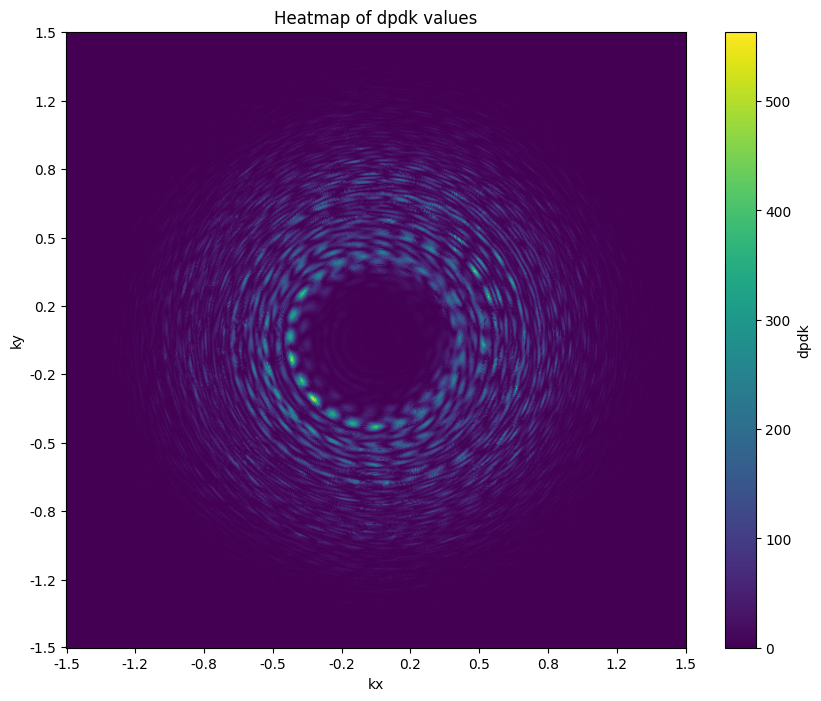

In [56]:
plt.rcParams['figure.figsize'] = (10, 8)  # Change the numbers to adjust width and height

plt_pkl("New_Standard_N_10_w_800.pkl", log=False)

In [17]:
df_std = pd.read_pickle("Standard.pkl")

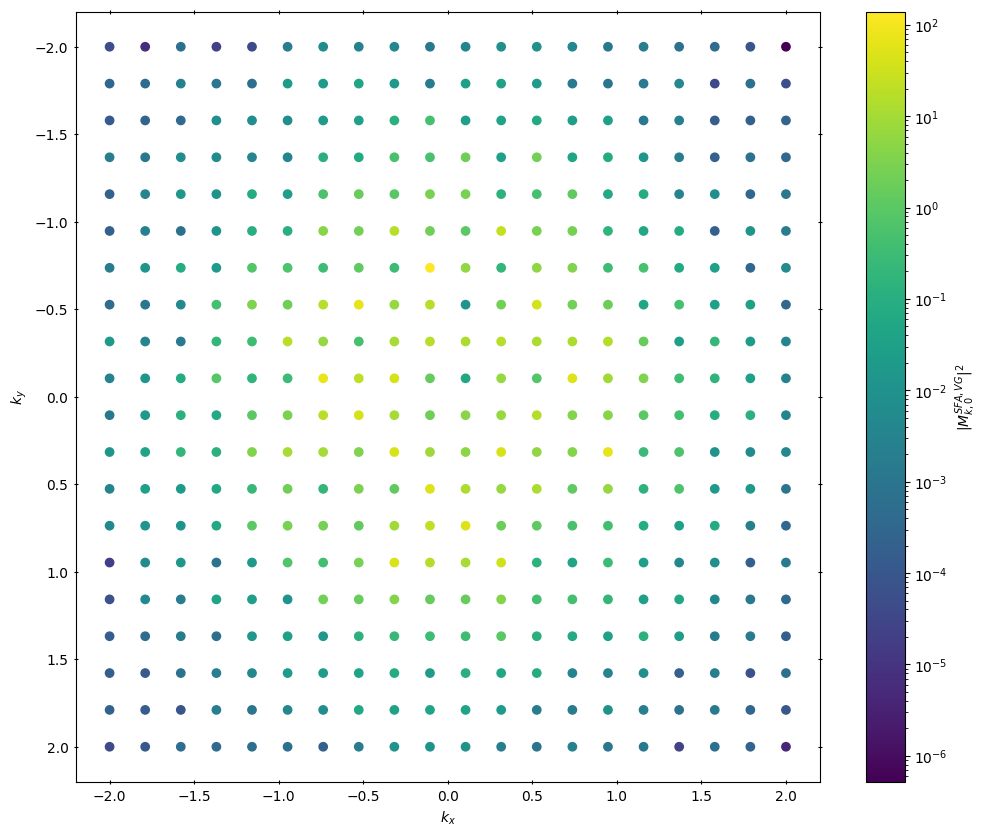

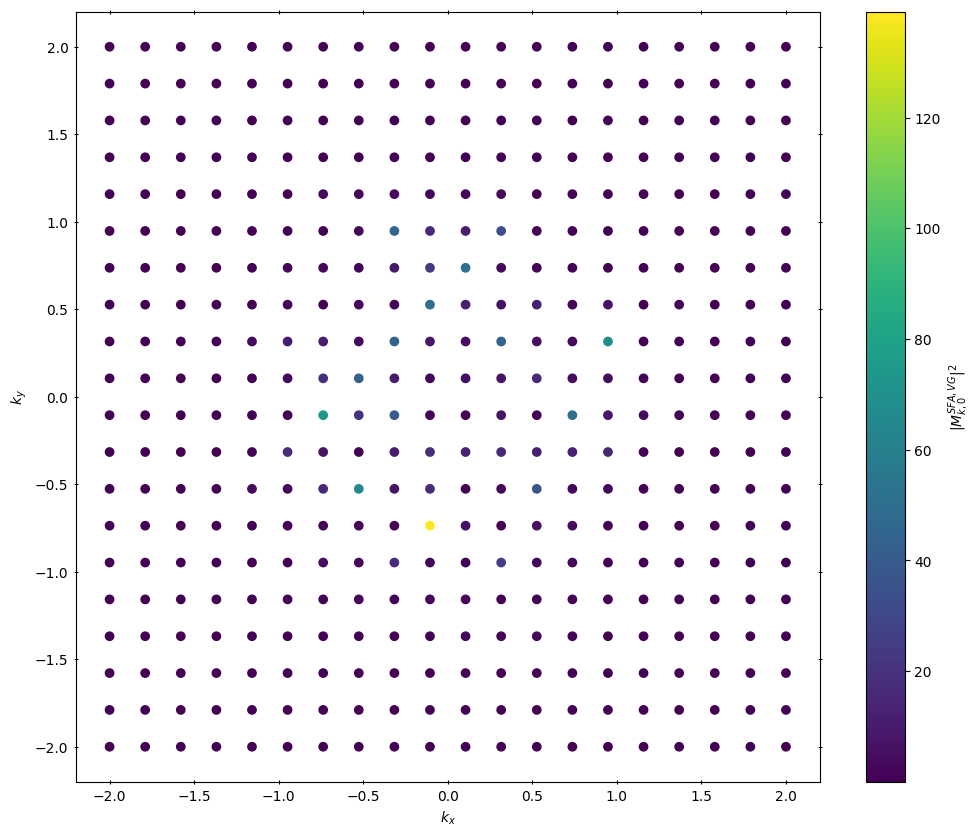

In [10]:

#plt_pkl("A2_is_0_15_windows.pkl", log=True)
plt_pkl("Standard.pkl", log=True)
plt_pkl("Standard.pkl", log=False)

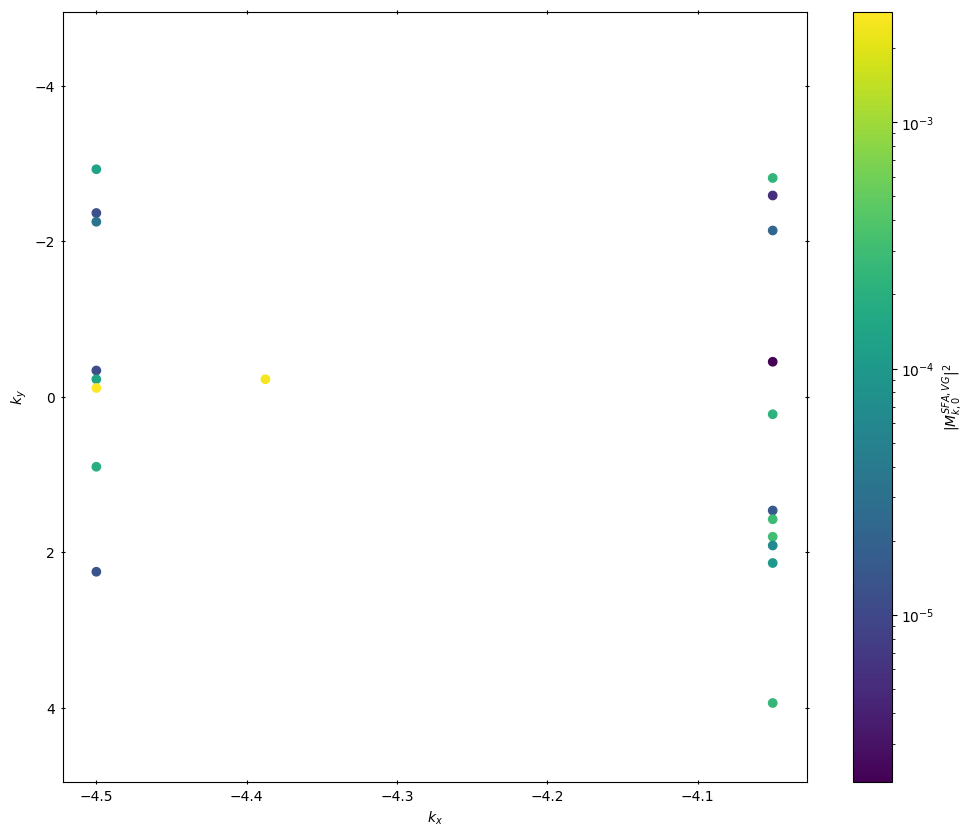

In [20]:
plt_pkl_diff("A2_is_0_15_windows.pkl", "Standard.pkl", log=True)

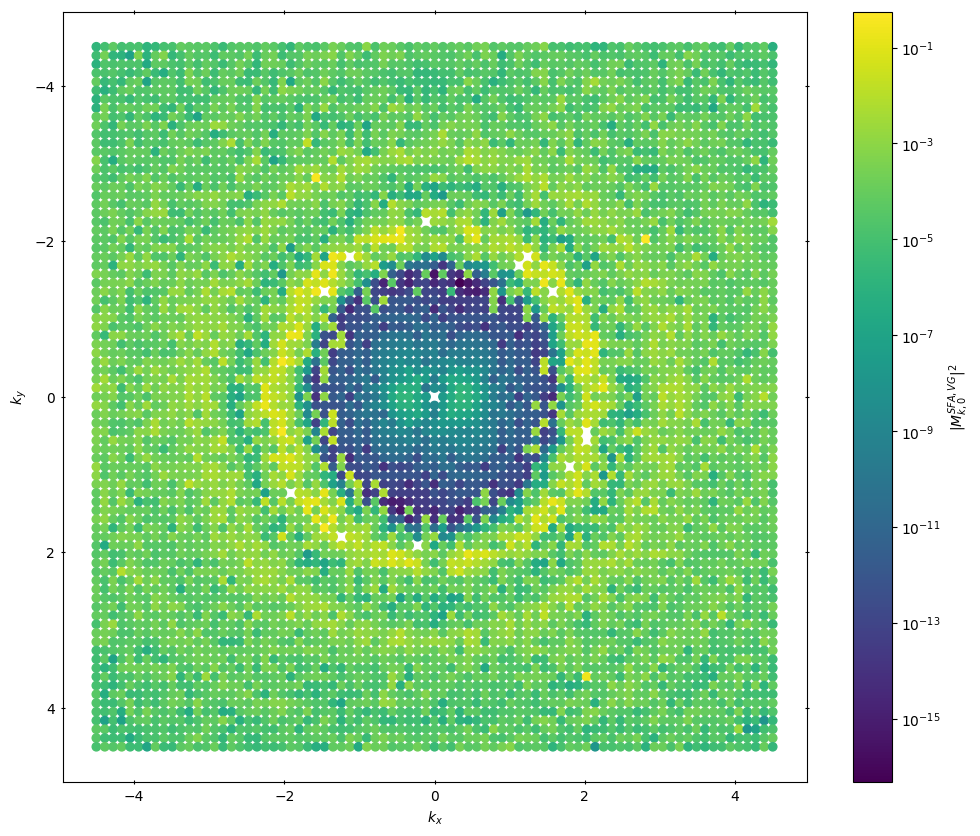

In [21]:
plt_pkl("A2_is_0_15_windows.pkl", log=True)

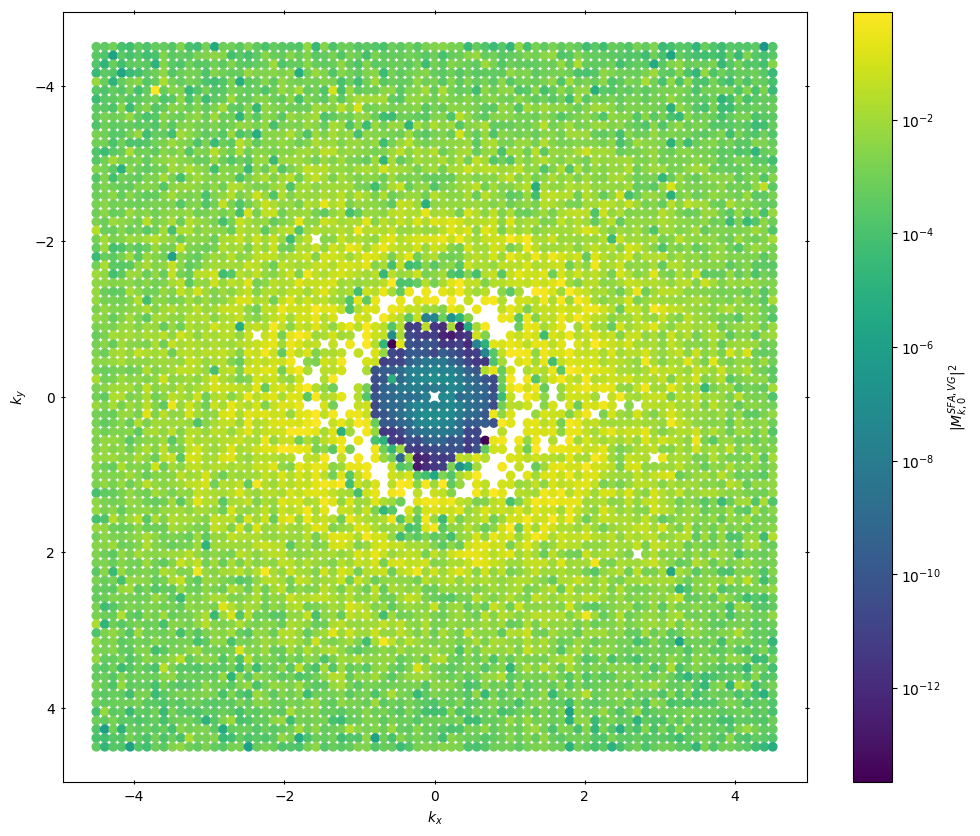

In [22]:
plt_pkl("ws_er_2ws_19_windows.pkl", log=True)

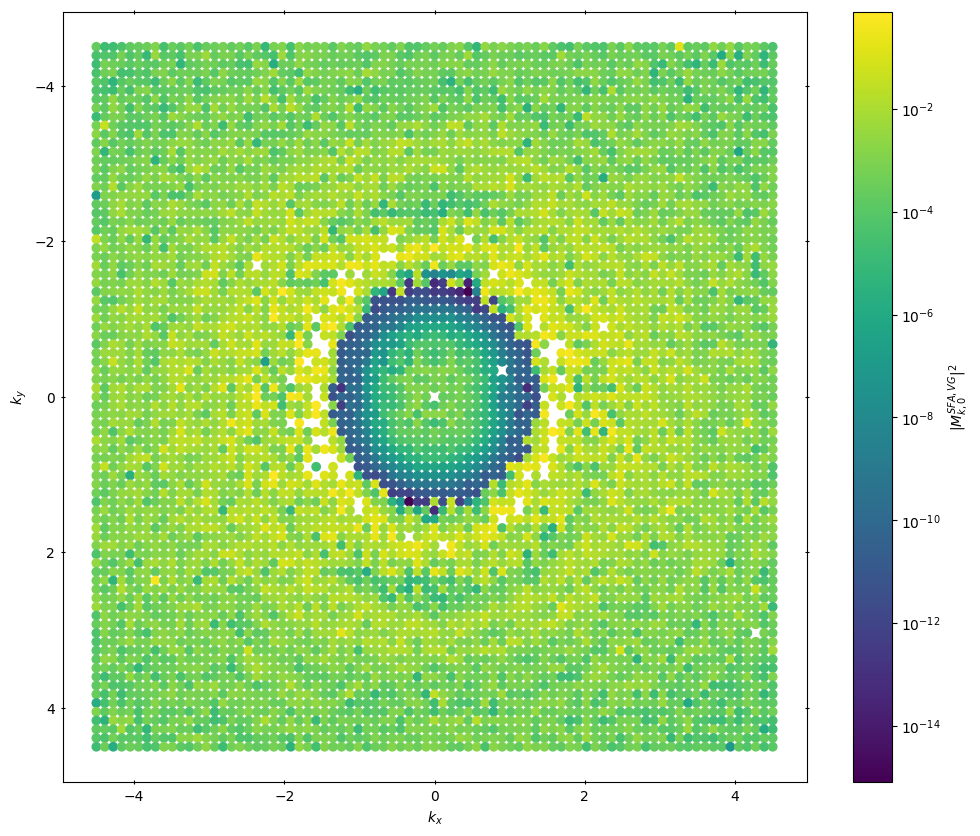

In [23]:
plt_pkl("I_er_e14_23_windows.pkl", log=True)

In [25]:
dd = pd.read_pickle("0002_windows.pkl")

In [26]:
pivot_table = dd.pivot(index='ky', columns='kx', values='dpdk')

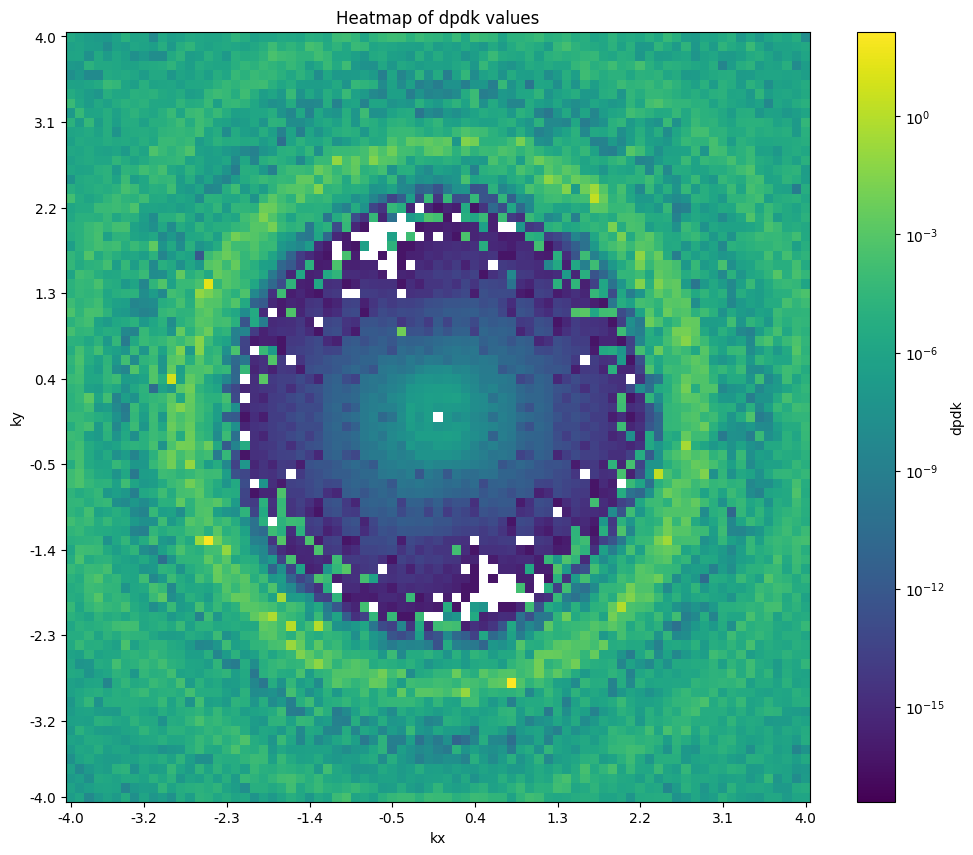

In [29]:
# Plot using imshow
plt.imshow(pivot_table, cmap='viridis', origin='lower', aspect='auto', norm=LogNorm())
plt.colorbar(label='dpdk')

# Set titles and labels
plt.title("Heatmap of dpdk values")
plt.xlabel("kx")
plt.ylabel("ky")

# Set x and y ticks at regular intervals
num_ticks = 10  # Set the number of ticks you want
kx_ticks = np.linspace(0, len(pivot_table.columns) - 1, num_ticks, dtype=int)
ky_ticks = np.linspace(0, len(pivot_table.index) - 1, num_ticks, dtype=int)

plt.xticks(kx_ticks, labels=[f"{pivot_table.columns[i]:.1f}" for i in kx_ticks])
plt.yticks(ky_ticks, labels=[f"{pivot_table.index[i]:.1f}" for i in ky_ticks])

# Display the plot
plt.show()

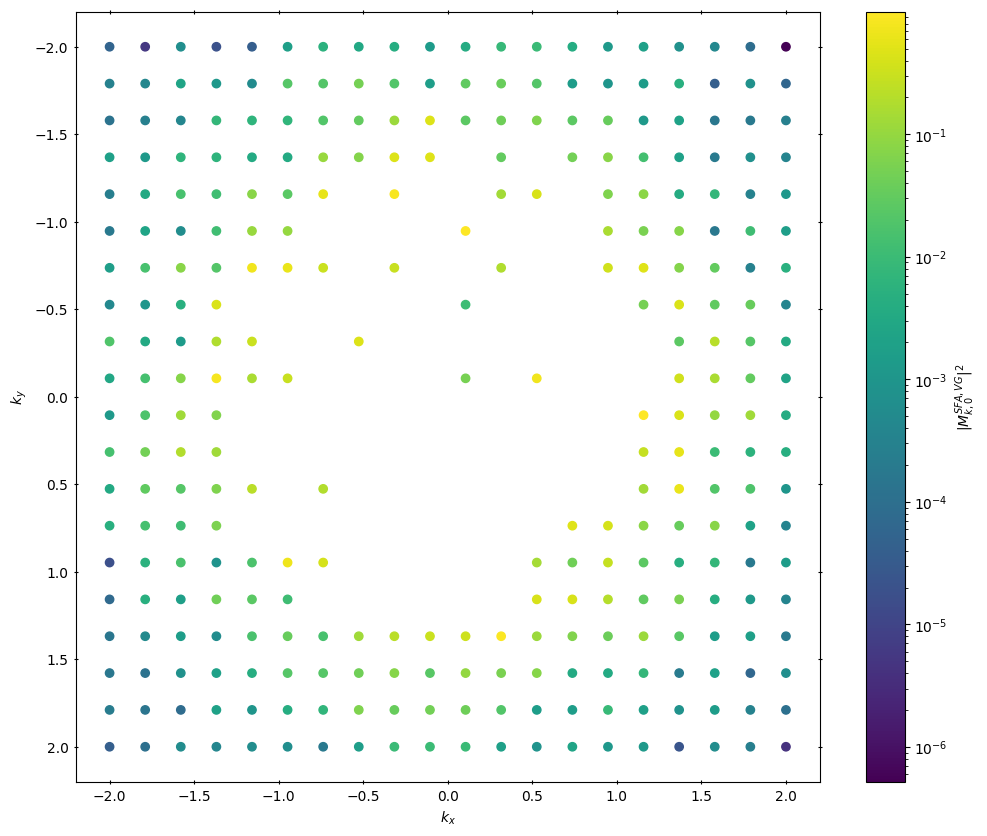

In [26]:
plot_log(df.loc[df["dpdk"] < 1, "kx"], df.loc[df["dpdk"] < 1, "ky"], df.loc[df["dpdk"] < 1, "dpdk"])

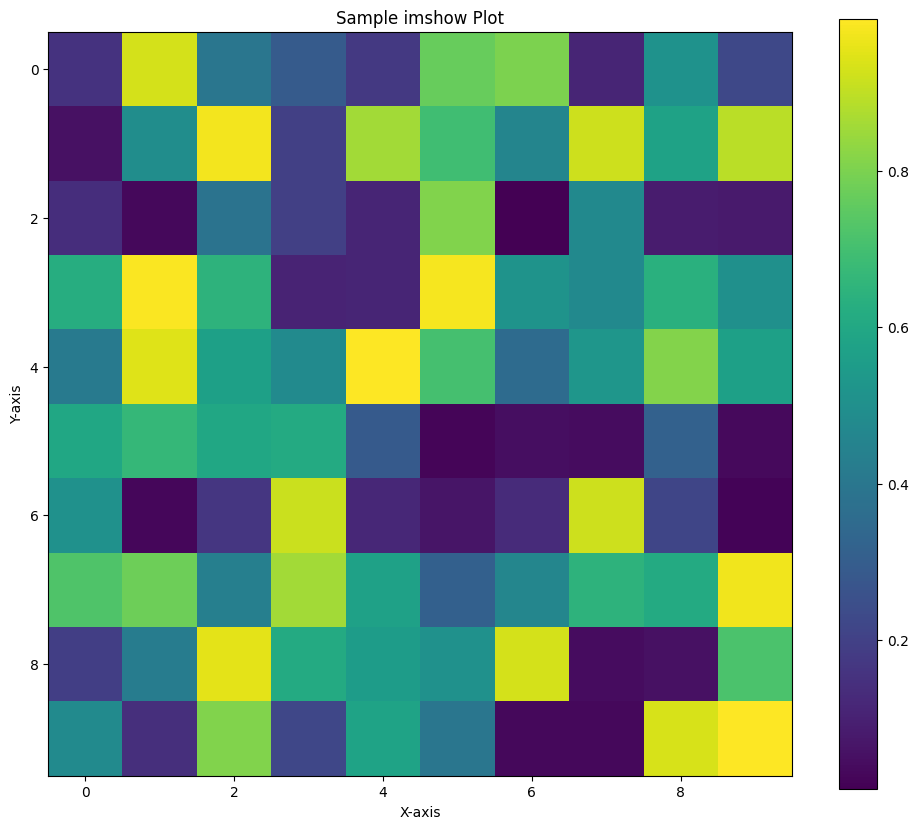

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Create a sample 2D array (image)
data = np.random.random((10, 10))

# Plot the array using imshow
plt.imshow(data, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Show a colorbar

# Set titles and labels
plt.title("Sample imshow Plot")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Display the plot
plt.show()


In [21]:
data

array([[0.15392428, 0.93243963, 0.39469155, 0.29209402, 0.17273539,
        0.76388455, 0.80161146, 0.11317452, 0.51216429, 0.22348446],
       [0.05284809, 0.49439339, 0.97563607, 0.19671773, 0.85851747,
        0.69386049, 0.45765757, 0.91942484, 0.57515391, 0.89040792],
       [0.14023207, 0.03168091, 0.38660645, 0.19567869, 0.11093183,
        0.80607234, 0.01001464, 0.47732692, 0.08633121, 0.08077971],
       [0.62132492, 0.98720108, 0.64571977, 0.10967791, 0.1131957 ,
        0.97998319, 0.51558769, 0.47896937, 0.63296408, 0.50381216],
       [0.4111991 , 0.94548506, 0.56931445, 0.48117961, 0.99419623,
        0.70283186, 0.35430441, 0.52785502, 0.81136928, 0.56971543],
       [0.5971445 , 0.66439804, 0.59504404, 0.61182216, 0.28851577,
        0.02408028, 0.04839342, 0.04426115, 0.31420603, 0.03320233],
       [0.50798947, 0.02779262, 0.16438587, 0.91402857, 0.1185613 ,
        0.06711918, 0.12941946, 0.91754156, 0.2174259 , 0.01920285],
       [0.72176921, 0.77867336, 0.4360125

length = 5
start_val = -4
end_val = 4
kxs = np.linspace(start_val, end_val, length)
kys = np.linspace(start_val, end_val, length)



kx_plot = []
ky_plot = []
values_plot = []
for i, kx in enumerate(kxs):
    values = [dp_dk(M_SFA_VG(t_f=T_s, t_0=0, k=np.array([kx, ky, 0]), w_sim=w_s, A_0=A_0_s, E_0=E_0_s, 
                       phase=phase_s,
                       epsilon=0.5, T_f=T_s)) for ky in kys]
    print(i)
    kx_plot.extend(kx * np.ones(length))
    ky_plot.extend(kys)
    values_plot.extend(values)
        